# 건설기계 오일 상태 분류 AI 경진대회

## 지식 증류 (Knowledge Distillation)

# Import

In [4]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
# Hyperparmeter Setting

CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

# Data Load

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Preprocessing

In [7]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [9]:
# Y_LABEL을 int형에서 object형으로 변환
train = train.astype({'Y_LABEL' : 'object'})

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   int64  
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   int64  
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

## 결측치 확인

In [11]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

In [12]:
temp=[]
ftemp=[]
#결측치 있는 칼럼 추출
for i in range(len(train.columns)):
    if train.count()[i]<len(train):
        temp.append(train.count().index[i])
    else:
        ftemp.append(train.count().index[i])

In [13]:
# 결측치 항목들

# CD                      1394
# FH2O                   10205
# FNOX                   10205
# FOPTIMETHGLY           10205
# FOXID                  10205
# FSO4                   10205
# FTBN                   10205
# FUEL                   10205
# K                       2299
# SOOTPERCENTAGE         10205
# U100                   11779
# U75                    11779
# U50                    11779
# U25                    11779
# U20                    11779
# U14                    11977
# U6                     11977
# U4                     11977
# V100                   10371

    - 전처리 목표
    - 0.component는 one hot사용
    - 1.결측치 특성 전체 제외된 것 (ftemp)
    - 2.test에 쓰일 특성만 활용 (te_in)
    - 3.결측치 보간해서 사용

### component - one hot vector 만들기

In [14]:
#one hot vector만들기
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

cat_col='COMPONENT_ARBITRARY'
ohe=pd.get_dummies(data=train[cat_col],columns=[cat_col])

In [15]:
train = pd.concat([train, ohe], axis=1)
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U4,V,V100,V40,ZN,Y_LABEL,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,0,NaN,154.0,75,0,0,0,1,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,1454.0,0,NaN,44.0,652,0,0,1,0,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,41081.0,0,NaN,72.6,412,1,0,1,0,0
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,0,NaN,133.3,7,0,0,0,1,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,0,NaN,133.1,128,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,0,NaN,135.4,16,0,0,0,1,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,0,14.5,117.5,1408,0,1,0,0,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,0,NaN,54.0,1301,0,0,0,1,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,18890.0,0,NaN,44.3,652,0,0,1,0,0


# 상관계수 구하기

<AxesSubplot:>

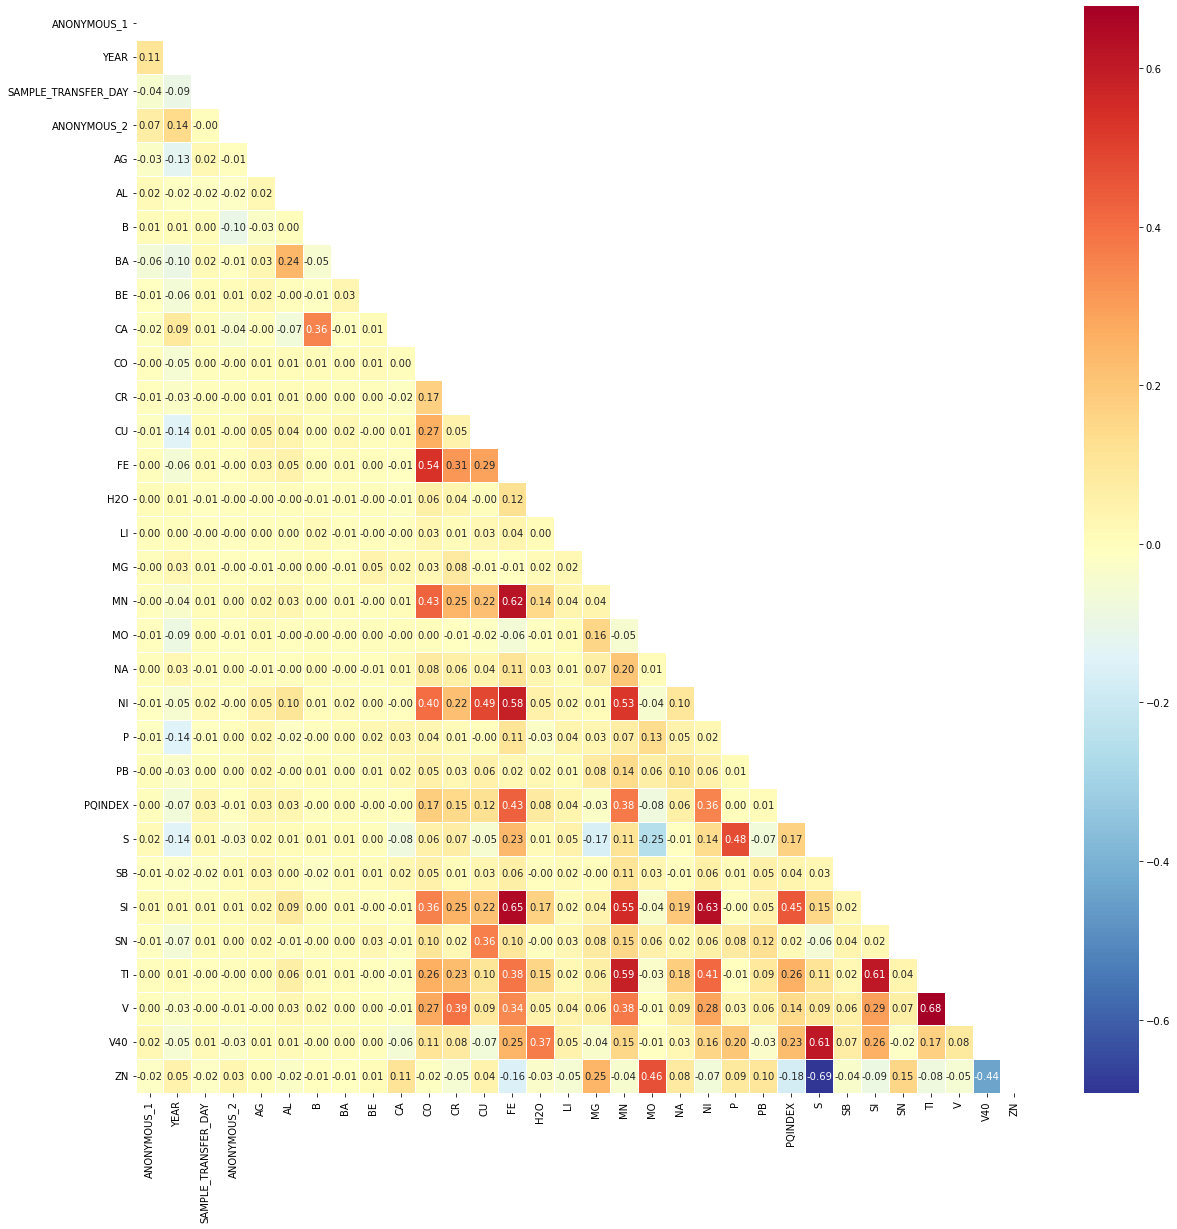

In [16]:
# Baseline에서는 결측치를 제거하지 않고 0으로 채움

test=train[ftemp]
# test.corr()
import seaborn as  sns
import matplotlib.pyplot as plt
mask=np.triu(test.corr())
plt.figure(figsize=(20,20))
sns.heatmap(test.corr(),annot=True,cmap='RdYlBu_r',fmt='.2f',linewidths=.5,mask=mask)

# plt.savefig('test.png',dpi=300)

In [17]:
train['Y_LABEL'].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

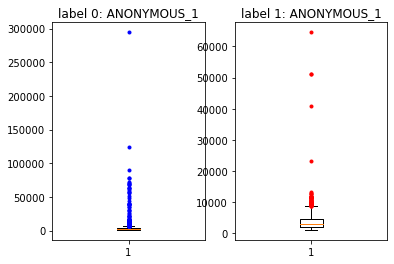

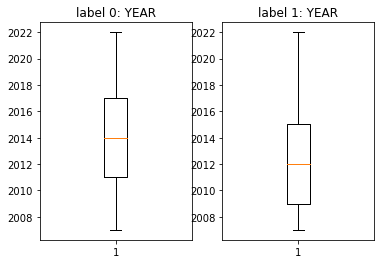

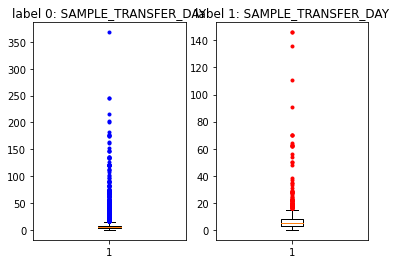

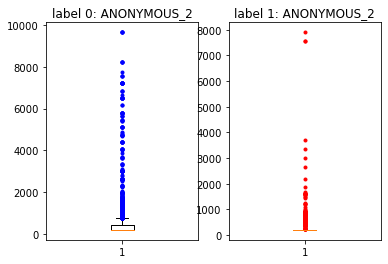

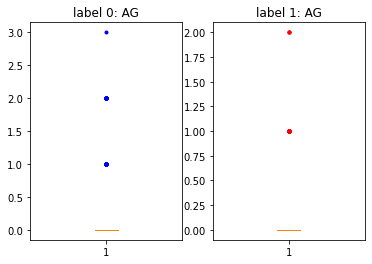

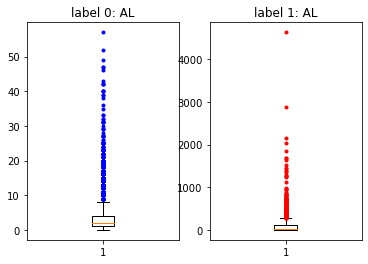

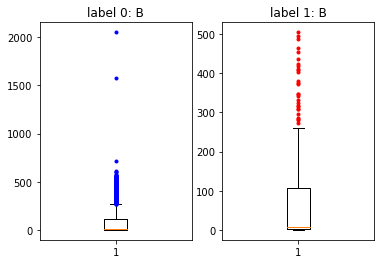

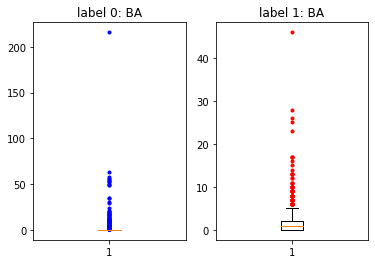

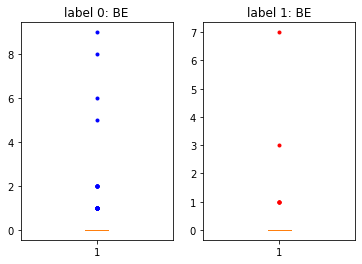

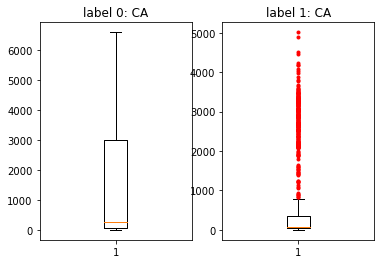

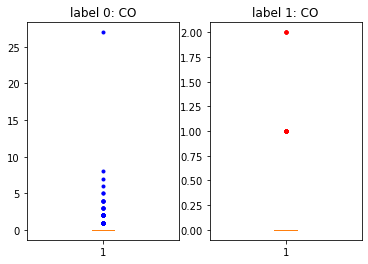

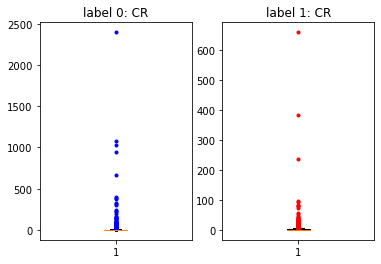

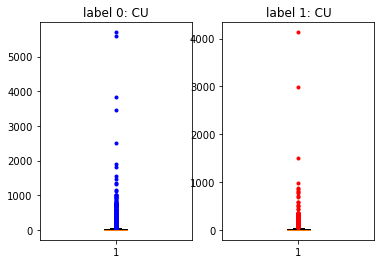

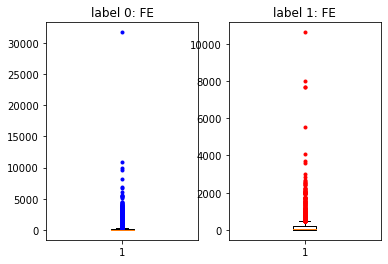

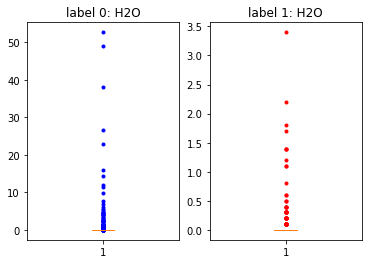

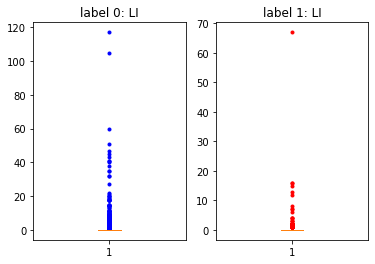

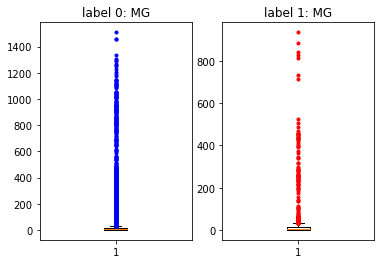

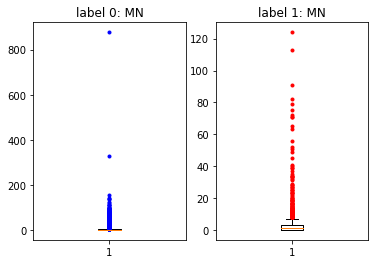

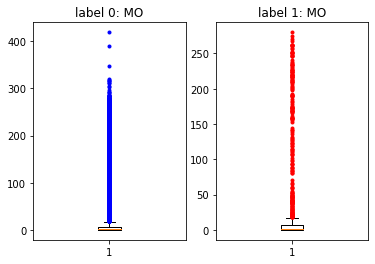

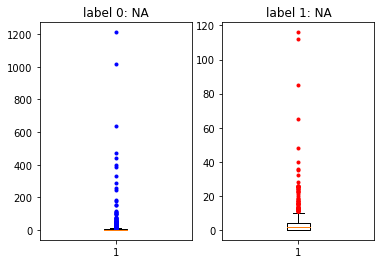

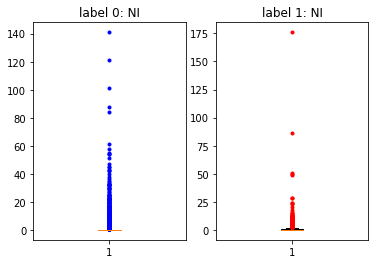

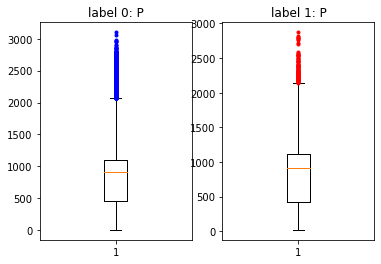

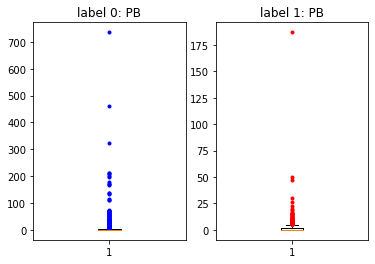

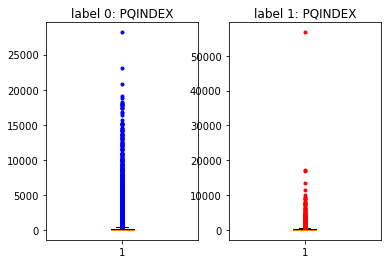

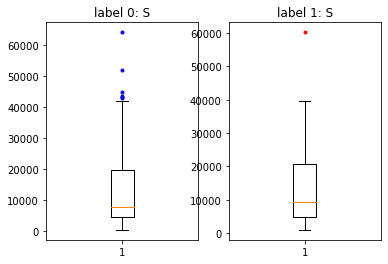

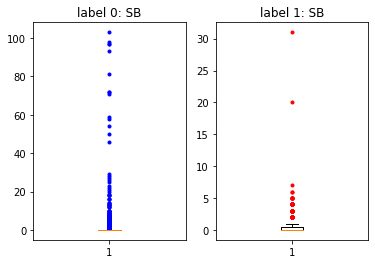

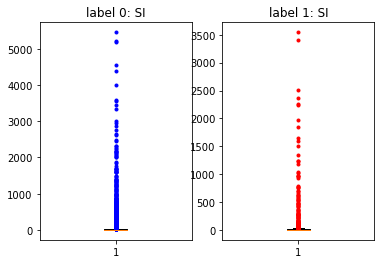

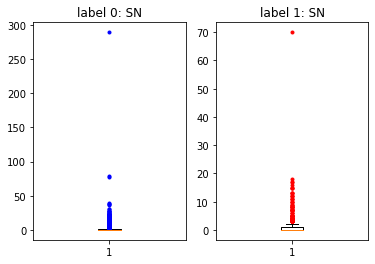

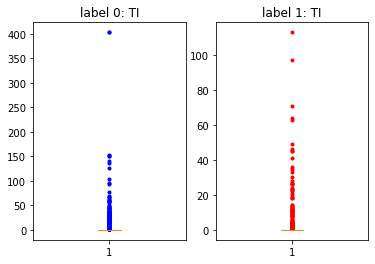

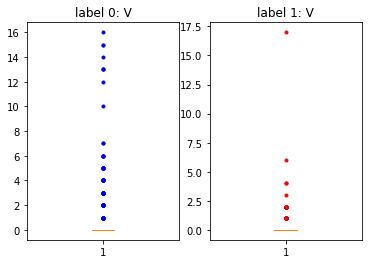

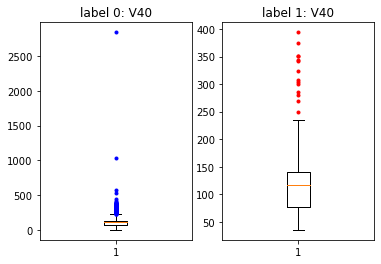

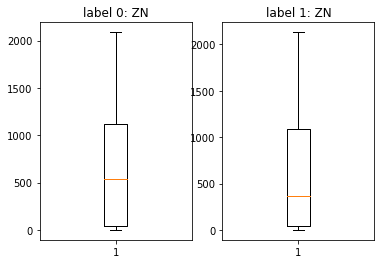

In [18]:
#y 레이블별로 나눠 보기
import matplotlib.pyplot as plt
train0=train[ftemp][train['Y_LABEL']==0]
train1=train[ftemp][train['Y_LABEL']==1]
cat_fe=['ID','COMPONENT_ARBITRARY','Y_LABEL']
num_fe=[x for x in train[ftemp] if x not in cat_fe]

for col in num_fe:
    # plt.figure(figsize=(12,10))
    fig,axs=plt.subplots(1,2)
    axs[0].boxplot(train0[col],sym='b.')
    axs[0].set_title("label 0: "+col)
    axs[1].boxplot(train1[col],sym='r.')
    axs[1].set_title("label 1: "+col)
    plt.show()
    
#결론 
# 영향 확실히 구별되는건 AL 나머지는 레이블간 유의미하게 파악가능한것이 적음
#추가로 데이터들의 outlier의 개수가 너무 많아 데이터 자체의 질이 높지 않다고 결론냄

### 결측치 채우는 4가지 방법
    - NaN 삭제 
        df.dropna()

    - NaN 0으로 바꾸기 (fillna)
        df.fillna(0)

    - NaN 평균치로 채우기 
        df.fillna({'칼럼명' : int(df['칼럼명].mean)}, inplace = True)
        inplace = True : 데이터 원본에 채운다는 의미
    
    - NaN 보간법으로 채우기 (선형에 비례하는 것으로 자주 사용)
        df.interpolate(method = 'linear')

### 데이터 전처리 및 모델 학습 시작

In [19]:
#preprocess
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

categorical_feature=['COMPONENT_ARBITRARY']
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [20]:
# 데이터 질이 좋지 않다고 판단했기에 결측치를 보간하는 x, 결측치가 있을시 해당 feature미사용

train35=train.loc[:,train.count()>14000] # 14000개 이상인 것만 사용
allx=train35.drop(['ID','Y_LABEL'],axis=1) # ID와 Y_LABEL Drop
ally=train['Y_LABEL']
test=test.drop(['ID'],axis=1)

## Split

In [21]:
# stratify로 인해 분포 class의 분포 비율까지 맞춰줌

trainx,valx,trainy,valy=train_test_split(allx,ally,test_size=0.2,random_state=1,stratify=ally)

## 카테고리 feature 변환

In [22]:
#카테고리 feature 변환
le = LabelEncoder()
for col in categorical_feature:    
    trainx[col] = le.fit_transform(trainx[col])
    valx[col] = le.transform(valx[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

## Knowledge Distillation X xgboost

In [25]:
import xgboost as xgb

In [26]:
#xgboost -> xgboost방식으로 teacher & student 모델 구성
xgc=xgb.XGBClassifier(learning_rate=0.05,n_estimators=1000,object='binary:logistic',eval_metric='auc',verbose=False)

In [27]:
#hyper para test
param_test={
    'max_depth':[5,6,7],
    'min_child_weight':[1,3,5]
}

In [31]:
from sklearn.model_selection import GridSearchCV
gridcv=GridSearchCV(xgc,param_grid=param_test,cv=3)

In [32]:
gridcv.fit(trainx,trainy)
print(gridcv.best_score_)
print(gridcv.best_params_)

[19:13:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.

[19:13:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.

[19:13:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.

[19:14:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.

[19:14:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.

[19:14:25] WARNING: /Users/runner/work/xgboos

In [37]:
#best params 적용하여 학습
xgc=xgb.XGBClassifier(learning_rate=0.05,n_estimators=1000,object='binary:logistic',min_child_weight=1,max_depth=6,eval_metric='auc',verbose=False)
xgc.fit(trainx,trainy)
teacher_proba=xgc.predict_proba(trainx)
val_proba=xgc.predict_proba(valx)

[19:53:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "object", "verbose" } are not used.



In [38]:
# xgc.fit(trainx,trainy)
predy=xgc.predict(valx)
print(f1_score(valy,predy,average='macro')*100)

81.93186645566946


In [39]:
print(f1_score(valy,predy)*100)

66.31853785900783


In [40]:
#student model
studentx=trainx[test_stage_features]
studenty=pd.Series([i for i,j in teacher_proba])
valstudenty=pd.Series([i for i,j in val_proba])

In [41]:
#hyper para test
xgs=xgb.XGBRegressor(learning_rate=0.03,n_estimators=500,eval_metric='rmse',objective='reg:linear',verbose=False)
param_test={
    'max_depth':[5,6,7],
    'min_child_weight':[1,3,5]
}
gridcv=GridSearchCV(xgs,param_grid=param_test,cv=3)
gridcv.fit(studentx,studenty)
print(gridcv.best_score_)
print(gridcv.best_params_)
# xgs.fit(studentx,studenty)
# predy=xgs.predict(valstx)
# print(accuracy_score(valsty,predy)*100)

[19:54:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:54:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[19:54:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squared

In [43]:
#student 모델도 best param으로 재학습
xgs=xgb.XGBRegressor(learning_rate=0.03,n_estimators=500,eval_metric='rmse',max_depth=5,min_child_weight=5,objective='reg:linear',verbose=False)
xgs.fit(studentx,studenty)
result=xgs.predict(test)

[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



In [44]:
#결과확인
tt=[]
for j in range(-7,110):
    i=j/100
    tt.append(len(result[result>(i-0.01)])-len(result[result>i]))


c=-0.07
for i in tt:
    print(f'{c:.2f}: {i}')
    c+=0.01

-0.07: 0
-0.06: 1
-0.05: 0
-0.04: 0
-0.03: 0
-0.02: 0
-0.01: 0
0.00: 0
0.01: 0
0.02: 0
0.03: 0
0.04: 1
0.05: 0
0.06: 0
0.07: 0
0.08: 0
0.09: 1
0.10: 0
0.11: 0
0.12: 0
0.13: 0
0.14: 0
0.15: 0
0.16: 0
0.17: 0
0.18: 0
0.19: 0
0.20: 0
0.21: 1
0.22: 1
0.23: 1
0.24: 0
0.25: 1
0.26: 1
0.27: 0
0.28: 1
0.29: 0
0.30: 0
0.31: 0
0.32: 0
0.33: 1
0.34: 0
0.35: 0
0.36: 0
0.37: 0
0.38: 2
0.39: 1
0.40: 1
0.41: 0
0.42: 0
0.43: 0
0.44: 0
0.45: 0
0.46: 0
0.47: 0
0.48: 0
0.49: 1
0.50: 2
0.51: 1
0.52: 0
0.53: 0
0.54: 1
0.55: 1
0.56: 2
0.57: 2
0.58: 5
0.59: 4
0.60: 5
0.61: 2
0.62: 3
0.63: 4
0.64: 6
0.65: 5
0.66: 7
0.67: 9
0.68: 11
0.69: 8
0.70: 10
0.71: 21
0.72: 11
0.73: 13
0.74: 21
0.75: 18
0.76: 22
0.77: 21
0.78: 25
0.79: 41
0.80: 50
0.81: 68
0.82: 70
0.83: 70
0.84: 101
0.85: 130
0.86: 145
0.87: 193
0.88: 213
0.89: 258
0.90: 301
0.91: 325
0.92: 345
0.93: 464
0.94: 486
0.95: 510
0.96: 491
0.97: 474
0.98: 371
0.99: 313
1.00: 163
1.01: 92
1.02: 57
1.03: 34
1.04: 11
1.05: 6
1.06: 1
1.07: 1
1.08: 1
1.09: 1


In [46]:
#분포를 보아 0.84~0.85가 적합하다 판단
xx=[0 if i>0.85 else 1for i in result]


out=pd.read_csv('sample_submission.csv')
out['Y_LABEL']=xx
out.to_csv('sample_submission.csv',index=False)